# **Machine Learning Assignment**

**Problem Statement:**
Accurate forecasting of energy consumption is critical for energy providers to manage grid
stability, for consumers to optimize their usage, and for developing strategies for
sustainability. Machine learning offers powerful tools for analyzing historical consumption
patterns and making accurate predictions about future demand. This project aims to build a
machine learning model to forecast household energy consumption based on historical timeseries data. To achieve this, you will work through the complete machine learning project
lifecycle: data collection, cleaning and preprocessing, exploratory analysis, model training,
and evaluation.

## **1. Data Collection**

Data is collected from kaggle hub. It is the recomended data set from UCI Machine Learning repository.

Available on :  https://www.kaggle.com/datasets/uciml/electric-powerconsumption-data-set

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import kagglehub
import os
from IPython.display import display

# Downloading latest versiono of UCI power consumption dataset
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")

# Constructing full path
file_path = os.path.join(path, "household_power_consumption.txt")

df = pd.DataFrame(pd.read_csv(file_path,
    sep=";",
    na_values="?",          # Missing values are marked with "?"
    low_memory=False ))

display(df.head())


100%|██████████| 19.4M/19.4M [00:00<00:00, 113MB/s] 

Extracting files...


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


## **2. Data Pre Processing**

**Steps:**

1. Combing Date and time and converting into datetime datatype.
2. Finding missing and duplicate values
3. Handling missing values using:
    1. Forward fill
    2. Backward fill
    3. Interpolation
4. Selecting the appropriate mathod for handling missing values by plotting the result and comparing.
5. Resampling and Aggregating to higher time frame.
6. Feature engineering, a new feature is derived from gloabl active power and global reactive power which is called powerfactor.

**1. Combining Date and Time and reformating**

In [2]:
# Combine date and time columns into one column
df["Datetime"] = pd.to_datetime(
    df["Date"] + " " + df["Time"],
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)
df.drop(columns=["Date", "Time"], inplace=True)
df.set_index("Datetime", inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
df.columns = df.columns.str.lower()
df.rename(columns={
    "Datetime": "datetime",
    "global_active_power": "global_active_power(kW)",
    "global_reactive_power": "global_reactive_power(kVAR)",
    "voltage": "voltage(V)",
    "global_intensity": "global_intensity(A)",
    "sub_metering_1": "sub_metering_1(Wh)",
    "sub_metering_2": "sub_metering_2(Wh)",
    "sub_metering_3": "sub_metering_3(Wh)"
}, inplace=True)
full_range = pd.date_range(start=df.index.min(),
                           end=df.index.max(),
                           freq="1min")
df = df.reindex(full_range)

**2.Finding missing and dupliacte values**

In [3]:
# check duplicate rows
duplicate_rows = df.index.duplicated().sum()
print(f"duplicate rows: {duplicate_rows}")
# no duplicate rows exist, since this is a time series data so we only need to check duplicate rows not individual values

# check missing values
all_missing_values = df.isnull().sum()
print(all_missing_values)

duplicate rows: 0
global_active_power(kW)        25979
global_reactive_power(kVAR)    25979
voltage(V)                     25979
global_intensity(A)            25979
sub_metering_1(Wh)             25979
sub_metering_2(Wh)             25979
sub_metering_3(Wh)             25979
dtype: int64


**3.Handling missing values**

Missing values are handled on minute basis, but for the purpose of better visualization, it is resampled on weekly basis just to see the difference between in different methods

In [4]:
df_weekly_resampled = df.resample('W').mean()

# Forward fill and resamoling on weekly basis
df_ffill = df.ffill()
df_ffill_weekly_resampled = df_ffill.resample('W').mean()

# Backward fill and resampling on weekly basis
df_bfill = df.bfill()
df_bfill_weekly_resampled = df_bfill.resample('W').mean()

# Interpolation and resampling on weekly basis
df_interpolated = df.interpolate(method="linear")
df_interpolated_weekly_resampled = df_interpolated.resample('W').mean()

**4. Comparing results of filled data (ffill, bfill, interpolated and original**

The results are compared, the graph is plotted for forward filled, backward filled, interpolation filled and original dataset on resampled data on weekly basis.

**Basis:**

Data is resampled on weekly basis just to visualize better, on dailly basis the difference is difficult to view and on monthly basis this difference is small enough to neglect.

/tmp/ipython-input-1289685261.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


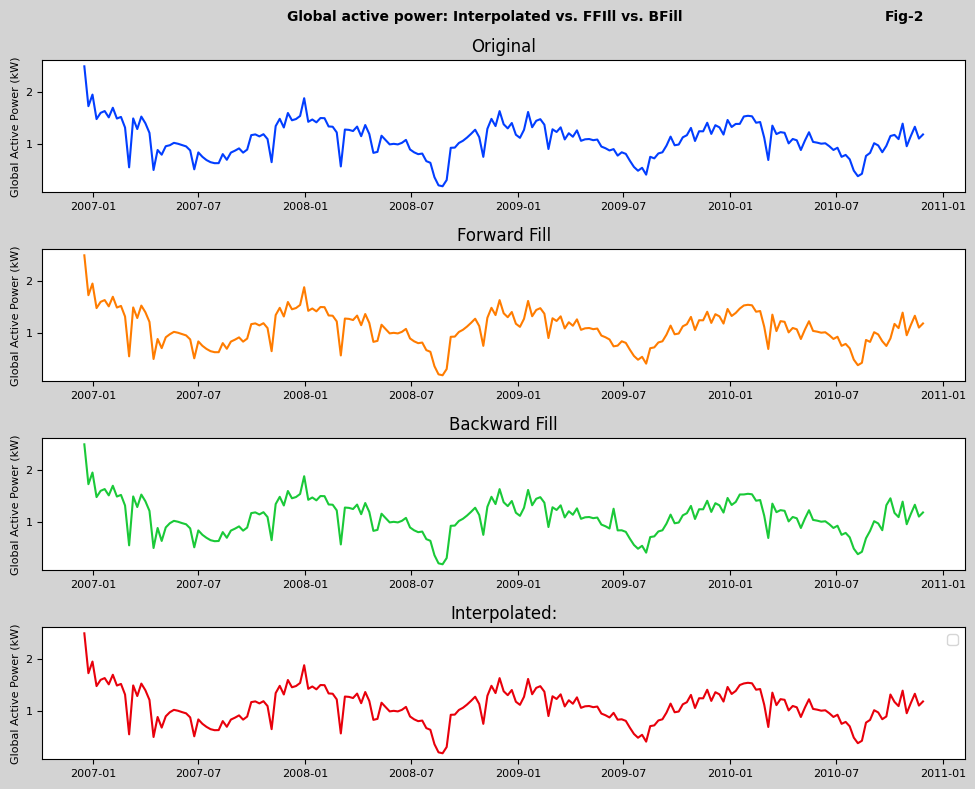

In [5]:
dataset = {
    "Original": df_weekly_resampled,
    "Forward Fill": df_ffill_weekly_resampled,
    "Backward Fill": df_bfill_weekly_resampled,
    "Interpolated:": df_interpolated_weekly_resampled
}

colors = sns.color_palette("bright", len(dataset),)
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=False, sharey=False)
# fig.patch.set_facecolor("lightyellow")
fig.patch.set_facecolor("lightgray")
fig.text(0.9, 0.98, "Fig-2", fontsize=10, fontweight="bold", va="top", ha="left")
axes = axes.flatten()

for ax, (label, df_temp), color in zip(axes, dataset.items(), colors):
    sns.lineplot(x=df_temp.index, y=df_temp["global_active_power(kW)"], ax=ax, color=color)
    ax.set_title(label, color="black")  # title in same color
    ax.set_xlabel("")
    ax.set_ylabel("Global Active Power (kW)", fontsize=8)
    ax.set_facecolor("white")
    ax.tick_params(axis="y", colors="black", labelsize=8)
    ax.tick_params(axis="x", colors="black", labelsize=8)

# plt.title(f"Global active power: Interpolated vs. FFIll vs. BFill")
plt.suptitle("Global active power: Interpolated vs. FFIll vs. BFill", fontsize=10, y=0.98, fontweight="bold")
plt.legend()
plt.tight_layout()
plt.show()

# So the final data set which will be used in entire machine learning project is df_interpolated

**5. Resampling and Aggregating to higher time frame**

**Final Data set:**

    The final data set after handling missing values which is to be used in entire in ML project is df_interpolated

**Resampling**

1. Global active power, gloabl reactive power, volatge and global intensity do not require summation while aggregation, We will use mean values for them.
2. Sub metering values needs to be aggregated and sumed as it show the consmption of electricity

In [6]:
# these variables will be used while resampling on different time basis in Exploratory Data Analysis
columns_requiring_mean = ["global_active_power(kW)", "global_reactive_power(kVAR)", "voltage(V)", "global_intensity(A)", "power_factor"]
columns_requiring_sum = ["sub_metering_1(Wh)", "sub_metering_2(Wh)", "sub_metering_3(Wh)"]

**6. Power Factor, a new  derived feature**

Gloabl active power is the actual direct power consumption and is measuerd in kW,
Global reactive power represents wastage and power dissipation. Both these factors are crucial in evaluating the system's efficiency.
In electrical engineering, power factor is derived from both these.

pf = Active power / ((active power)2 * (reactive power)2)1/2

In [7]:
import numpy as np

df_interpolated["apparent_power(kVA)"] = np.sqrt(
    df_interpolated["global_active_power(kW)"]**2 +
    df_interpolated["global_reactive_power(kVAR)"]**2
)

# Calculate Power Factor (PF = P / S)
df_interpolated["power_factor"] = (
    df_interpolated["global_active_power(kW)"] /
    df_interpolated["apparent_power(kVA)"]
)

# Replace infinities (in case apparent power is 0) with NaN
df_interpolated["power_factor"] = df_interpolated["power_factor"].replace([np.inf, -np.inf], np.nan)
display(df_interpolated.head(2))

,global_active_power(kW),global_reactive_power(kVAR),voltage(V),global_intensity(A),sub_metering_1(Wh),sub_metering_2(Wh),sub_metering_3(Wh),apparent_power(kVA),power_factor
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,4.236671,0.995121
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,5.377704,0.996708


## **3. Exploratory Data Analysis**

1. Power Factor Analysis

###**1. Power Factor Analysis in different time scales**

**Resampling Data Set**
1. Daily
2. Weekly
3. Monthly
4. Quarterly

In [8]:
# Resampling data on daily basis
df_interpolated_mean_daily = df_interpolated[columns_requiring_mean].resample("D").mean()
df_interpolated_sum_daily  = df_interpolated[columns_requiring_sum].resample("D").sum()
df_interpolated_daily_resampled = pd.concat([df_interpolated_mean_daily, df_interpolated_sum_daily], axis=1)
print("Daily data set shape: ",df_interpolated_daily_resampled.shape)

# Resampling data on weekly basis
df_interpolated_mean_weekly = df_interpolated[columns_requiring_mean].resample("W").mean()
df_interpolated_sum_weekly  = df_interpolated[columns_requiring_sum].resample("W").sum()
df_interpolated_weekly_resampled = pd.concat([df_interpolated_mean_weekly, df_interpolated_sum_weekly], axis=1)
print("Weekly data set shape: ",df_interpolated_weekly_resampled.shape)

# Resampling data on monthly basis
df_interpolated_mean_me = df_interpolated[columns_requiring_mean].resample("ME").mean()
df_interpolated_sum_me  = df_interpolated[columns_requiring_sum].resample("ME").sum()
df_interpolated_me_resampled = pd.concat([df_interpolated_mean_me, df_interpolated_sum_me], axis=1)
print("Monthly data set shape: ", df_interpolated_me_resampled.shape)

# Resampling data on quarterly basis
df_interpolated_mean_quarter = df_interpolated[columns_requiring_mean].resample("QE").mean()
df_interpolated_sum_quarter  = df_interpolated[columns_requiring_sum].resample("QE").sum()
df_interpolated_quarter_resampled = pd.concat([df_interpolated_mean_quarter, df_interpolated_sum_quarter], axis=1)
print("Quarterly data set shape: ", df_interpolated_quarter_resampled.shape)


Daily data set shape:  (1442, 8)
Weekly data set shape:  (207, 8)
Monthly data set shape:  (48, 8)
Quarterly data set shape:  (17, 8)


**Plotting Results**
1. Power factor (new derived feature)
2. Global active power
3. Global reactive power

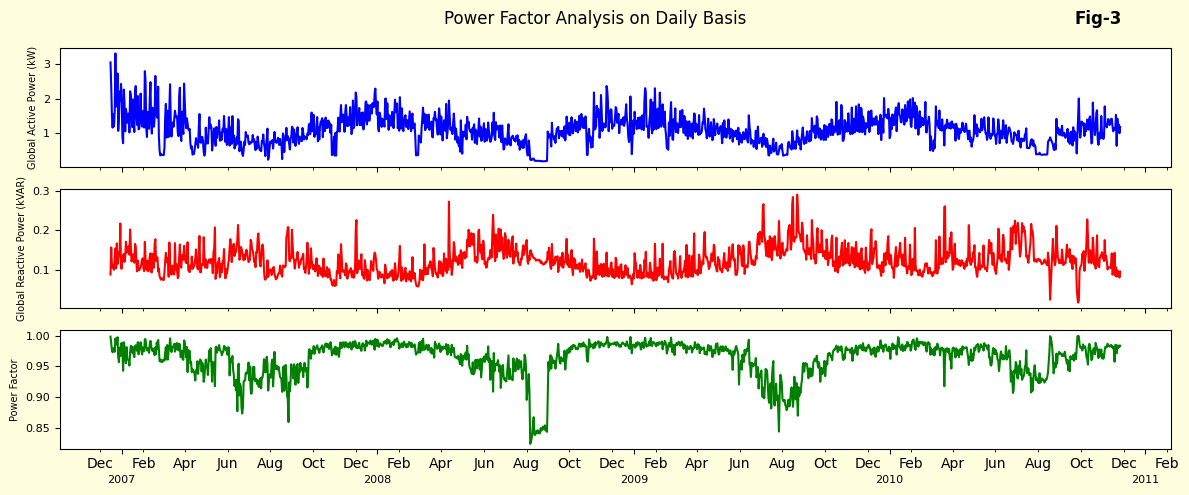

In [9]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)
fig.suptitle("Power Factor Analysis on Daily Basis", fontsize=12, y=0.98)
fig.text(0.9, 0.98, "Fig-3", fontsize=12, fontweight="bold", va="top", ha="left")

fig.patch.set_facecolor("lightyellow")

# Common x-axes
common_x_axis_daily = df_interpolated_daily_resampled.index
common_x_axis_weekly = df_interpolated_weekly_resampled.index

# Plot definitions
plots = [
    (common_x_axis_daily, df_interpolated_daily_resampled["global_active_power(kW)"], "blue", "Global Active Power Daily", "Global Active Power (kW)"),
    (common_x_axis_daily, df_interpolated_daily_resampled["global_reactive_power(kVAR)"], "red", "Global Reactive Power Daily", "Global Reactive Power (kVAR)"),
    (common_x_axis_daily, df_interpolated_daily_resampled["power_factor"], "green", "Power Factor Daily", "Power Factor"),
]

# Loop over plots
for ax, (x, y, color, title, ylabel) in zip(axes, plots):
    ax.plot(x, y, color=color)
    # ax.set_title(title, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=7)
    ax.tick_params(axis="y", labelsize=8)
    ax.tick_params(axis="x", labelsize=8)
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
    ax.xaxis.set_minor_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter("%b"))
    ax.tick_params(axis="x", which="major", pad=15)

plt.tight_layout()
plt.show()


###**2. Distribution Analysis of Electrical Parameters**

In [10]:
# cols = ["global_active_power(kW)",
#         "global_reactive_power(kVAR)",
#         "voltage(V)",
#         "global_intensity(A)", "power_factor"]

# fig, axes = plt.subplots(len(cols), 2, figsize=(12, 4 * len(cols)))

# for i, col in enumerate(cols):
#     # Histogram
#     axes[i, 0].hist(df_interpolated_daily_resampled[col], bins=50, rwidth=0.8)
#     axes[i, 0].set_title(f"Histogram of {col}")
#     axes[i, 0].set_xlabel(col)
#     axes[i, 0].set_ylabel("Frequency")

#     # Boxplot
#     axes[i, 1].boxplot(df_interpolated_daily_resampled[col].dropna(), vert=False)
#     axes[i, 1].set_title(f"Boxplot of {col}")
#     axes[i, 1].set_xlabel(col)

# fig.tight_layout(pad=3.0)
# plt.show()


# df_interpolated_weekly_resampled[cols].hist(bins=50, figsize=(12,8), grid=False, rwidth=0.8)
# plt.suptitle("Histograms of Main Factors Related to power", fontsize=16)
# plt.show()


In [11]:
# resampling and aggregation
df_interpolated_daily_resampled.isna().sum()
np.isinf(df_interpolated_daily_resampled.values).sum()

# Helper functions for plotting and getting stats
def distributionAndBoxPlot(df, title, fig_no):
  fig, axes = plt.subplots(1, 2, figsize=(10, 4))
  fig.patch.set_facecolor("lightyellow")
  fig.text(0.9, 0.98, f"Fig-{fig_no}", fontsize=10, fontweight="bold", va="top", ha="left")
  ax = axes[0]
  ax.set_facecolor("white")
  sns.histplot(df[title],
             ax=ax, color="lightblue")
  ax.set_title("Histogram", fontsize=10)
  ax.tick_params(axis="x", labelsize=8)
  ax.tick_params(axis="y", labelsize=8)

  ax = axes[1]
  ax.set_facecolor("white")
  sns.boxplot(x=df[title],
              color="lightgreen", ax=ax, width=0.3)
  ax.set_title("Boxplot", fontsize=10)
  ax.set_ylabel("")
  ax.tick_params(axis="x", labelsize=8)
  ax.tick_params(axis="y", labelsize=8)

  fig.tight_layout(pad=3.0)
  plt.show()

def get_stats(df, col):
  values = df[col].dropna()
  median = np.round(np.median(values), 4).item()
  mean   = np.round(np.mean(values), 4).item()
  std    = np.round(np.std(values), 4).item()
  q1     = np.round(np.percentile(values, 25), 4).item()
  q3     = np.round(np.percentile(values, 75), 4).item()
  iqr    = np.round(q3 - q1, 4).item()

  lower_bound = q1 - 1.5 * iqr
  upper_bound = q3 + 1.5 * iqr
  outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
  return {
        "median": median,
        "mean": mean,
        "std": std,
        "q1": q1,
        "q3": q3,
        "iqr": iqr,
        "lower_bound": lower_bound,
        "upper_bound": upper_bound,
        "outliers_count": outliers.shape[0],
        # "outliers_index": outliers.index
    }


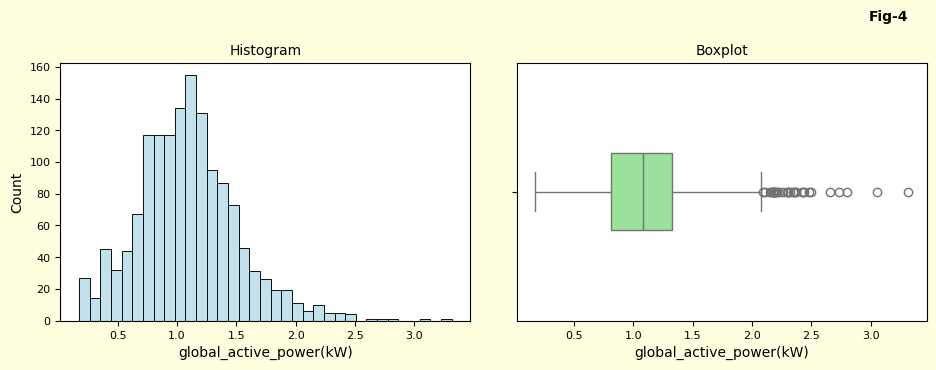

{'median': 1.0792,
 'mean': 1.0913,
 'std': 0.421,
 'q1': 0.8112,
 'q3': 1.3229,
 'iqr': 0.5117,
 'lower_bound': 0.04364999999999997,
 'upper_bound': 2.09045,
 'outliers_count': 32}

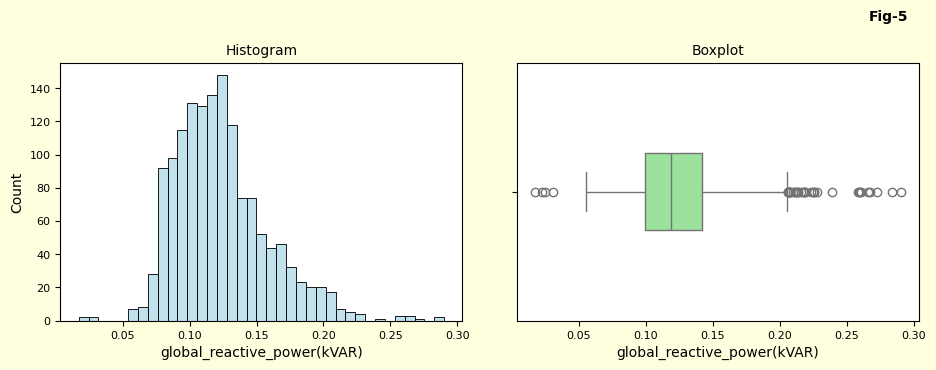

{'median': 0.119,
 'mean': 0.1236,
 'std': 0.0348,
 'q1': 0.099,
 'q3': 0.1415,
 'iqr': 0.0425,
 'lower_bound': 0.035250000000000004,
 'upper_bound': 0.20525,
 'outliers_count': 38}

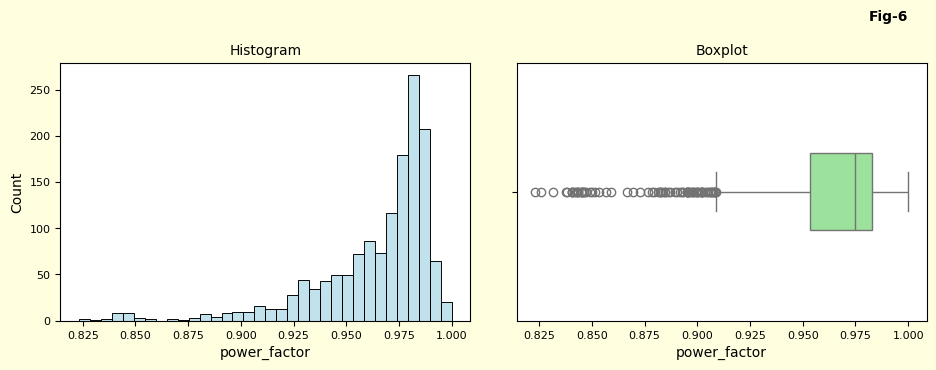

{'median': 0.9747,
 'mean': 0.9638,
 'std': 0.0287,
 'q1': 0.9533,
 'q3': 0.9829,
 'iqr': 0.0296,
 'lower_bound': 0.9089,
 'upper_bound': 1.0273,
 'outliers_count': 77}

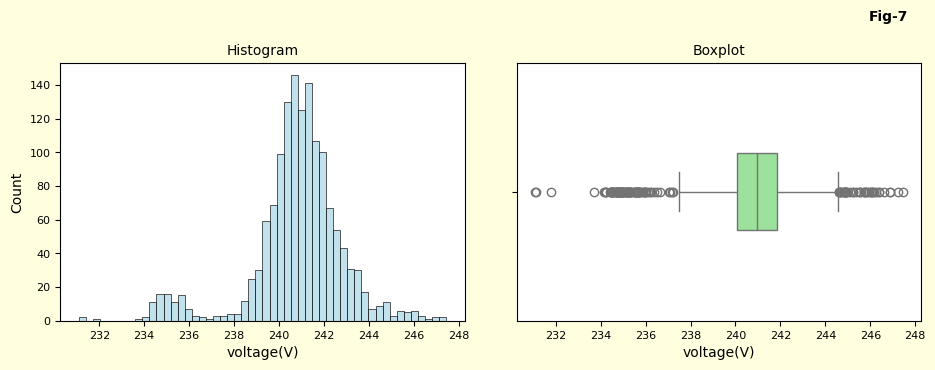

{'median': 240.9627,
 'mean': 240.8304,
 'std': 2.0493,
 'q1': 240.0684,
 'q3': 241.8698,
 'iqr': 1.8014,
 'lower_bound': 237.3663,
 'upper_bound': 244.5719,
 'outliers_count': 131}

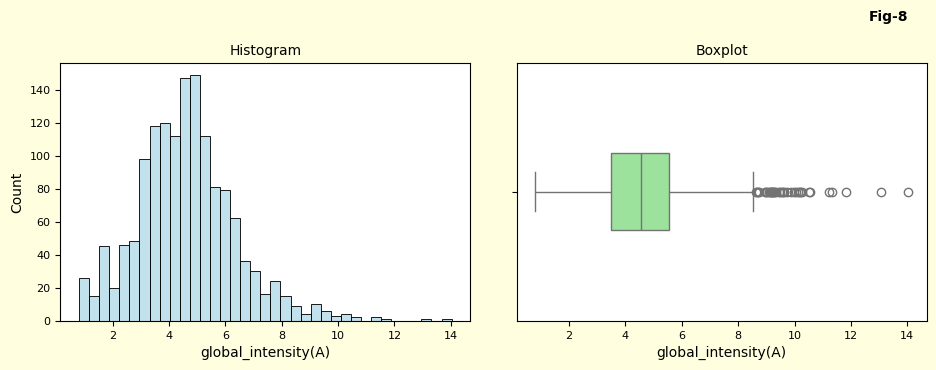

{'median': 4.5494,
 'mean': 4.6258,
 'std': 1.7431,
 'q1': 3.5008,
 'q3': 5.5392,
 'iqr': 2.0384,
 'lower_bound': 0.4431999999999996,
 'upper_bound': 8.5968,
 'outliers_count': 36}

In [12]:
# Global Active Power Distribution
distributionAndBoxPlot(df_interpolated_daily_resampled,"global_active_power(kW)", 4)
globalActivePowerStats = get_stats(df_interpolated_daily_resampled, "global_active_power(kW)")
display(globalActivePowerStats)
# Global Reactive Power
distributionAndBoxPlot(df_interpolated_daily_resampled,"global_reactive_power(kVAR)", 5)
globalReactivePowerStats = get_stats(df_interpolated_daily_resampled, "global_reactive_power(kVAR)")
display(globalReactivePowerStats)
# Power factor
distributionAndBoxPlot(df_interpolated_daily_resampled,"power_factor", 6)
powerFactorStats = get_stats(df_interpolated_daily_resampled, "power_factor")
display(powerFactorStats)
# voltage distribution and stats
distributionAndBoxPlot(df_interpolated_daily_resampled,"voltage(V)", 7)
voltageStats = get_stats(df_interpolated_daily_resampled, "voltage(V)")
display(voltageStats)
# global intensity distribution
distributionAndBoxPlot(df_interpolated_daily_resampled,"global_intensity(A)", 8)
globalIntensityStats = get_stats(df_interpolated_daily_resampled, "global_intensity(A)")
display(globalIntensityStats)

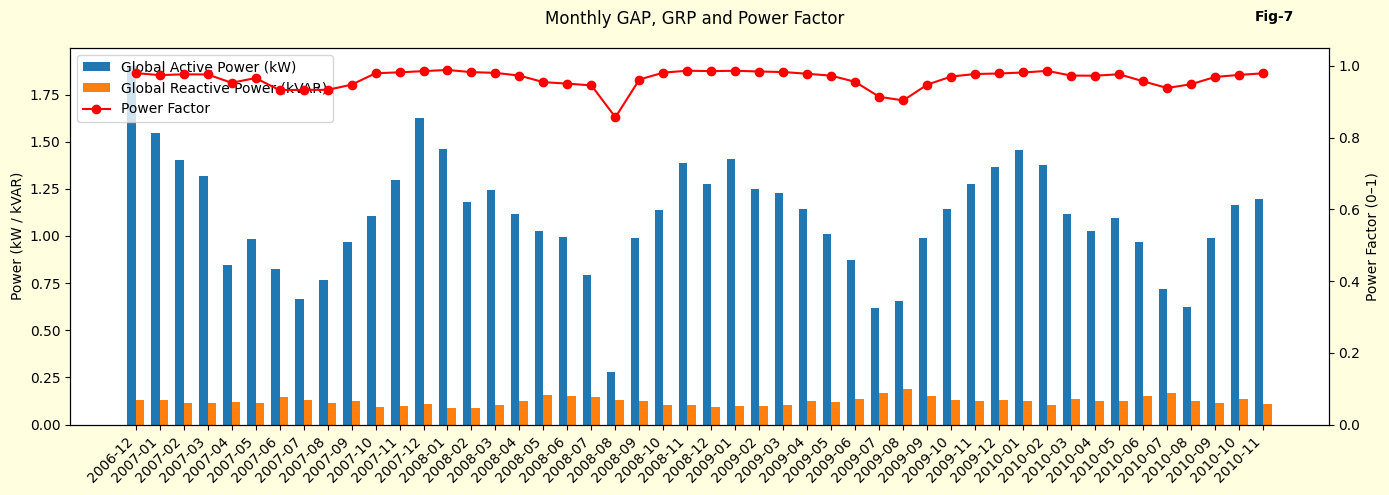

In [13]:
# Comparitive analysis
import numpy as np
import matplotlib.pyplot as plt
cols = ["global_active_power(kW)", "global_reactive_power(kVAR)", "power_factor"]
dfm = df_interpolated_me_resampled

x = np.arange(len(dfm.index))
w = 0.35  # bar width for two bars

fig, ax1 = plt.subplots(figsize=(14, 5))
fig.suptitle("Monthly GAP, GRP and Power Factor", y=0.98)
fig.text(0.9, 0.98, "Fig-7", fontsize=10, fontweight="bold", va="top", ha="left")
fig.patch.set_facecolor("lightyellow")

# Bars: GAP & GRP
ax1.bar(x - w/2, dfm[cols[0]].values, width=w, label="Global Active Power (kW)")
ax1.bar(x + w/2, dfm[cols[1]].values, width=w, label="Global Reactive Power (kVAR)")
ax1.set_ylabel("Power (kW / kVAR)")
ax1.set_xticks(x)
ax1.set_xticklabels([d.strftime("%Y-%m") for d in dfm.index], rotation=45, ha="right")

# PF as line on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, dfm[cols[2]].values, marker="o", label="Power Factor", color="red")
ax2.set_ylabel("Power Factor (0–1)")
ax2.set_ylim(0, 1.05)

# Combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()
plt.show()


### **3. Analysis for Sub Meterings**

Metering has units of Wh
Metering is analysed in relation with Global Active Power
1. sub_metering_one
    - kitchen appliances (dishwasher, microwave etc)
2. sub_metering_two
    - laundry appliances
3. sub_metering_three
    - heating and cooling appliances

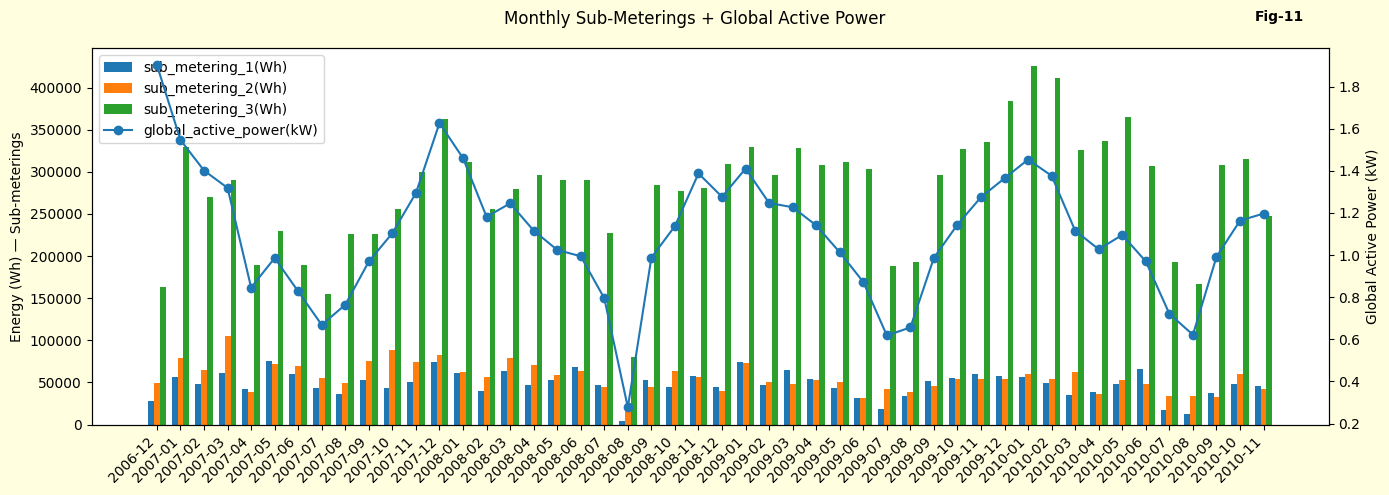

In [14]:
dfm = df_interpolated_me_resampled  # monthly aggregated index (DatetimeIndex)

cols = ["sub_metering_1(Wh)", "sub_metering_2(Wh)", "sub_metering_3(Wh)"]
gap  = "global_active_power(kW)"  # already monthly-aggregated in your df

x = np.arange(len(dfm.index))          # positions
w = 0.25                               # bar width

fig, ax1 = plt.subplots(figsize=(14, 5))
fig.suptitle("Monthly Sub-Meterings + Global Active Power", y=0.98)
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-11", fontsize=10, fontweight="bold", va="top", ha="left")

# Grouped bars
ax1.bar(x - w, dfm[cols[0]].values, width=w, label=cols[0])
ax1.bar(x,      dfm[cols[1]].values, width=w, label=cols[1])
ax1.bar(x + w,  dfm[cols[2]].values, width=w, label=cols[2])

ax1.set_ylabel("Energy (Wh) — Sub-meterings")
ax1.set_xticks(x)
ax1.set_xticklabels([d.strftime("%Y-%m") for d in dfm.index], rotation=45, ha="right")

# Global Active Power (GAP) is line on secondary axis
ax2 = ax1.twinx()
ax2.plot(x, dfm[gap].values, marker="o", label=gap)
ax2.set_ylabel("Global Active Power (kW)")

# Legends
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc="upper left")

plt.tight_layout()
plt.show()


**Sub_metering_1 Distribution**

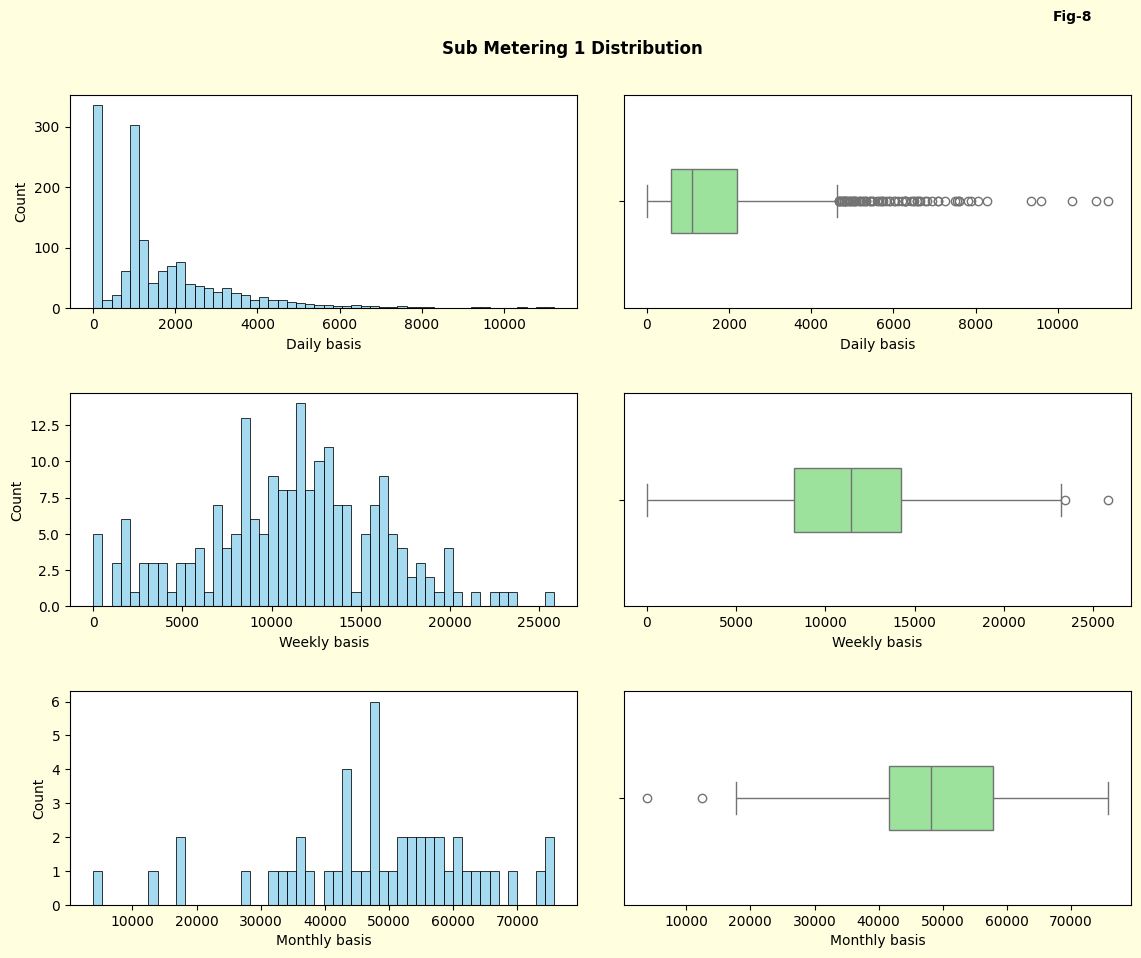

In [15]:
import seaborn as sns

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("Sub Metering 1 Distribution", fontsize=12, fontweight="bold", y=0.95)
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-8", fontsize=10, fontweight="bold", va="top", ha="left")

# Daily
sns.histplot(df_interpolated_daily_resampled["sub_metering_1(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[0, 0])
sns.boxplot(x=df_interpolated_daily_resampled["sub_metering_1(Wh)"], color="lightgreen", width=0.3, ax=axes[0, 1], orient="h")

# Weekly
sns.histplot(df_interpolated_weekly_resampled["sub_metering_1(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[1, 0])
sns.boxplot(x=df_interpolated_weekly_resampled["sub_metering_1(Wh)"], color="lightgreen", width=0.3, ax=axes[1, 1], orient="h")

# Monthly
sns.histplot(df_interpolated_me_resampled["sub_metering_1(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[2, 0])
sns.boxplot(x=df_interpolated_me_resampled["sub_metering_1(Wh)"], color="lightgreen", width=0.3, ax=axes[2, 1], orient="h")

# Labels
axes[0, 0].set_xlabel("Daily basis")
axes[1, 0].set_xlabel("Weekly basis")
axes[2, 0].set_xlabel("Monthly basis")

axes[0, 1].set_xlabel("Daily basis")
axes[1, 1].set_xlabel("Weekly basis")
axes[2, 1].set_xlabel("Monthly basis")

fig.tight_layout(pad=3.0)
plt.show()


In [16]:
daily_stats_sub_metering_1 = get_stats(df_interpolated_daily_resampled, "sub_metering_1(Wh)")
weekly_stats_sub_metering_1 = get_stats(df_interpolated_weekly_resampled, "sub_metering_1(Wh)")
monthly_stats_sub_metering_1 = get_stats(df_interpolated_me_resampled, "sub_metering_1(Wh)")

**Sub_metering_2_Distribution**

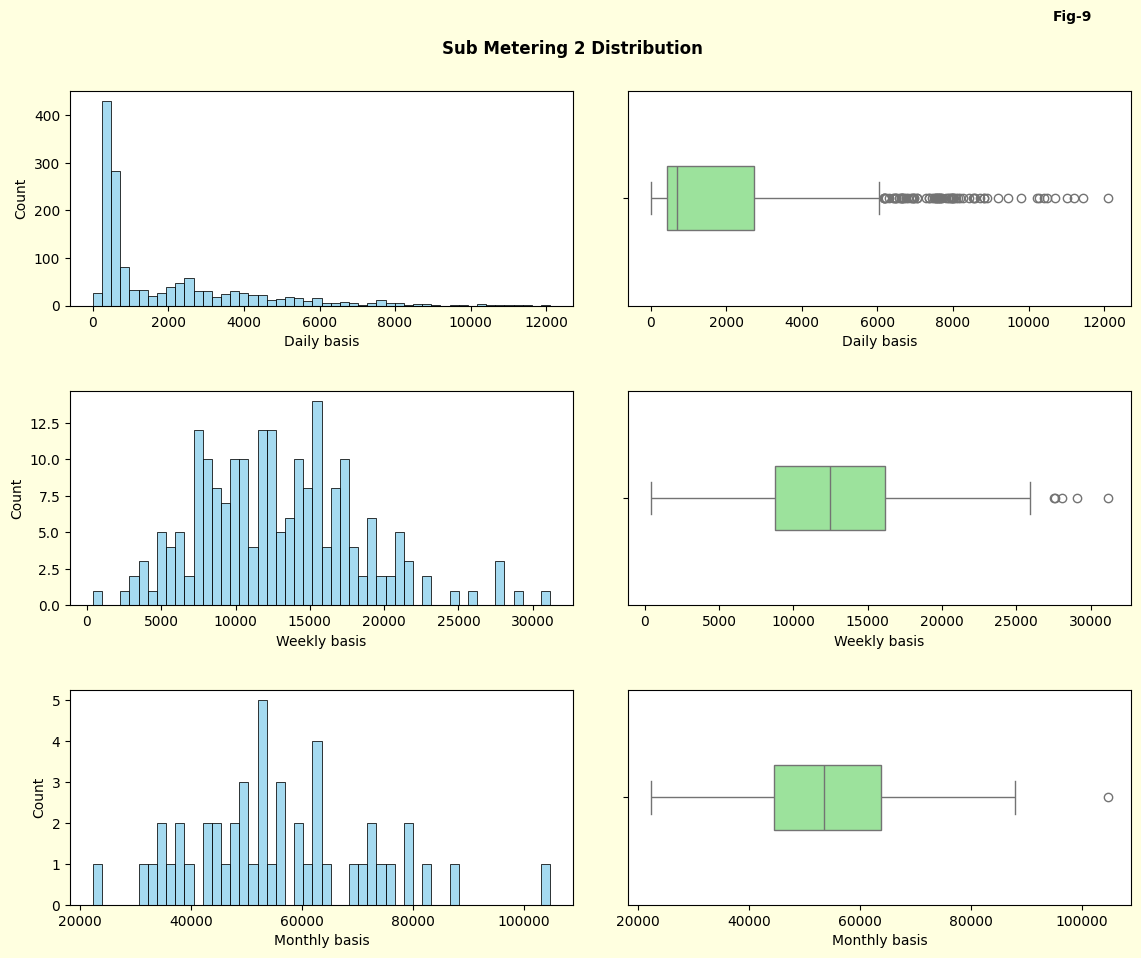

In [17]:

fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("Sub Metering 2 Distribution", fontsize=12, fontweight="bold", y=0.95)
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-9", fontsize=10, fontweight="bold", va="top", ha="left")

# Daily
sns.histplot(df_interpolated_daily_resampled["sub_metering_2(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[0, 0])
sns.boxplot(x=df_interpolated_daily_resampled["sub_metering_2(Wh)"], color="lightgreen", width=0.3, ax=axes[0, 1], orient="h")

# Weekly
sns.histplot(df_interpolated_weekly_resampled["sub_metering_2(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[1, 0])
sns.boxplot(x=df_interpolated_weekly_resampled["sub_metering_2(Wh)"], color="lightgreen", width=0.3, ax=axes[1, 1], orient="h")

# Monthly
sns.histplot(df_interpolated_me_resampled["sub_metering_2(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[2, 0])
sns.boxplot(x=df_interpolated_me_resampled["sub_metering_2(Wh)"], color="lightgreen", width=0.3, ax=axes[2, 1], orient="h")

# Labels
axes[0, 0].set_xlabel("Daily basis")
axes[1, 0].set_xlabel("Weekly basis")
axes[2, 0].set_xlabel("Monthly basis")

axes[0, 1].set_xlabel("Daily basis")
axes[1, 1].set_xlabel("Weekly basis")
axes[2, 1].set_xlabel("Monthly basis")

fig.tight_layout(pad=3.0)
plt.show()

In [18]:
daily_stats_sub_metering_2 = get_stats(df_interpolated_daily_resampled, "sub_metering_2(Wh)")
weekly_stats_sub_metering_2 = get_stats(df_interpolated_weekly_resampled, "sub_metering_2(Wh)")
monthly_stats_sub_metering_2 = get_stats(df_interpolated_me_resampled, "sub_metering_2(Wh)")

**Sub_metering_3_Distribution**

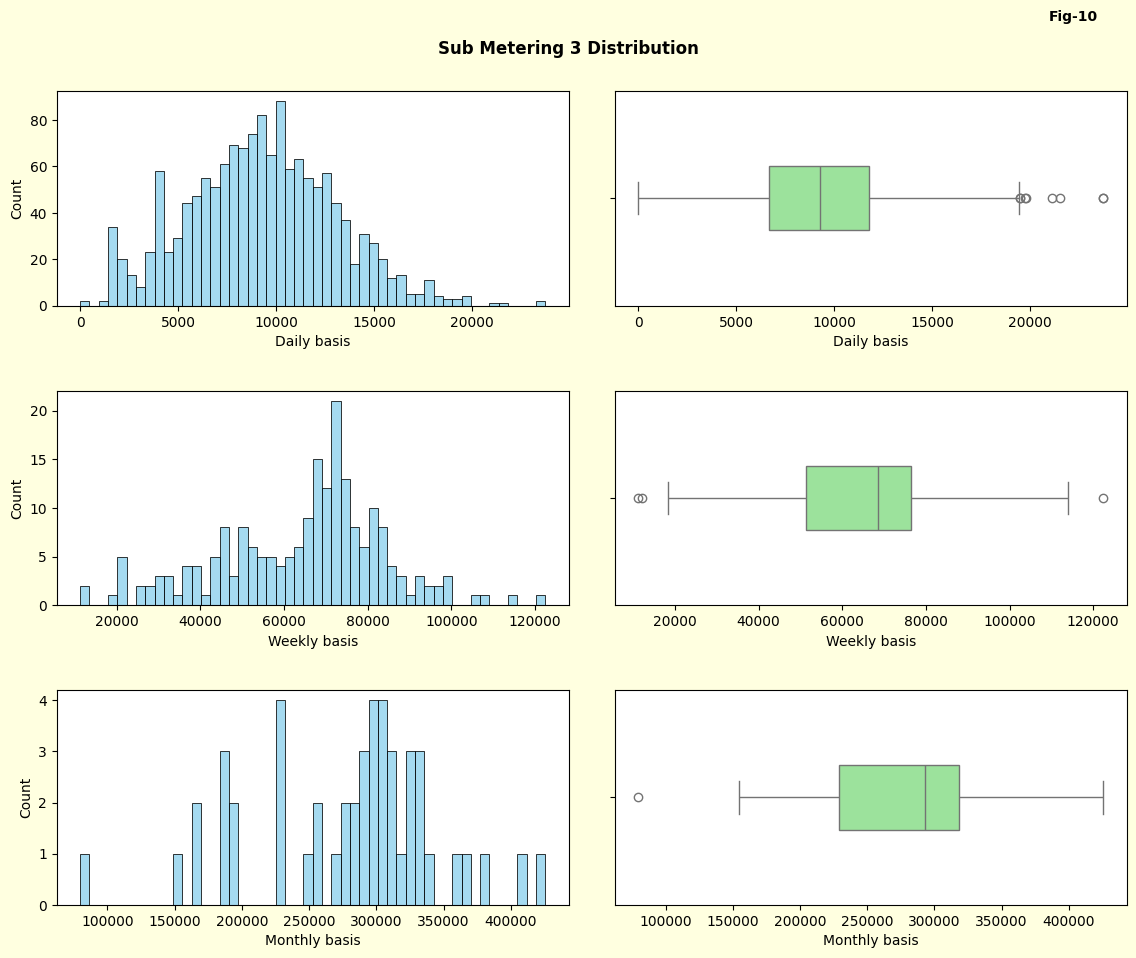

In [19]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))
fig.suptitle("Sub Metering 3 Distribution", fontsize=12, fontweight="bold", y=0.95)
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-10", fontsize=10, fontweight="bold", va="top", ha="left")

# Daily
sns.histplot(df_interpolated_daily_resampled["sub_metering_3(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[0, 0])
sns.boxplot(x=df_interpolated_daily_resampled["sub_metering_3(Wh)"], color="lightgreen", width=0.3, ax=axes[0, 1], orient="h")

# Weekly
sns.histplot(df_interpolated_weekly_resampled["sub_metering_3(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[1, 0])
sns.boxplot(x=df_interpolated_weekly_resampled["sub_metering_3(Wh)"], color="lightgreen", width=0.3, ax=axes[1, 1], orient="h")

# Monthly
sns.histplot(df_interpolated_me_resampled["sub_metering_3(Wh)"], bins=50, kde=False, color="skyblue", ax=axes[2, 0])
sns.boxplot(x=df_interpolated_me_resampled["sub_metering_3(Wh)"], color="lightgreen", width=0.3, ax=axes[2, 1], orient="h")

# Labels
axes[0, 0].set_xlabel("Daily basis")
axes[1, 0].set_xlabel("Weekly basis")
axes[2, 0].set_xlabel("Monthly basis")

axes[0, 1].set_xlabel("Daily basis")
axes[1, 1].set_xlabel("Weekly basis")
axes[2, 1].set_xlabel("Monthly basis")

fig.tight_layout(pad=3.0)
plt.show()

In [20]:
daily_stats_sub_metering_3 = get_stats(df_interpolated_daily_resampled, "sub_metering_3(Wh)")
weekly_stats_sub_metering_3 = get_stats(df_interpolated_weekly_resampled, "sub_metering_3(Wh)")
monthly_stats_sub_metering_3 = get_stats(df_interpolated_me_resampled, "sub_metering_3(Wh)")

### **3. Data Preparation**


**1. Handling Outliers**

In [21]:
df_daily = df_interpolated_daily_resampled.copy()
df_monthly = df_interpolated_me_resampled.copy()

display(df_daily.head(1))

,global_active_power(kW),global_reactive_power(kVAR),voltage(V),global_intensity(A),power_factor,sub_metering_1(Wh),sub_metering_2(Wh),sub_metering_3(Wh)
2006-12-16,3.053475,0.088187,236.243763,13.082828,0.998768,0.0,546.0,4926.0


**Before Winsorization**

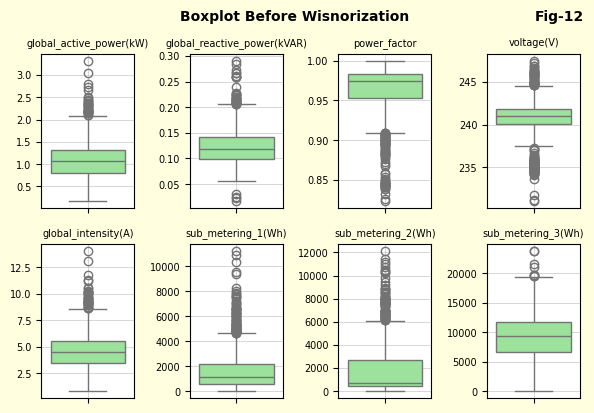

In [22]:
columns = ["global_active_power(kW)","global_reactive_power(kVAR)","power_factor","voltage(V)","global_intensity(A)", "sub_metering_1(Wh)", "sub_metering_2(Wh)", "sub_metering_3(Wh)"]

fig = plt.figure(figsize=(6, 8))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-12", fontsize=10, fontweight="bold", va="top", ha="left")
for i, col in enumerate(columns):
  ax = plt.subplot(4, 4, i + 1)
  sns.boxplot(y=df_daily[col],color="lightgreen",legend="brief",)
  plt.tick_params(axis="both", labelsize=7)
  ax.set_title(col, fontsize=7)
  ax.set_ylabel("")
  ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.7)

plt.suptitle("Boxplot Before Wisnorization", fontsize=10, fontweight="bold", y=0.98)
plt.tight_layout()
plt.show()

**After Winsorization**

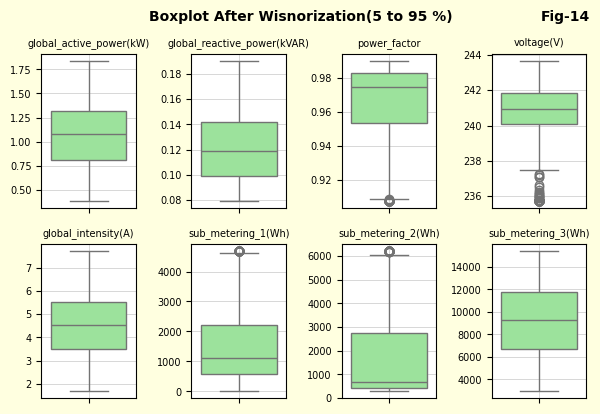

In [23]:
for col in columns:
    upper_limit = df_daily[col].quantile(0.95)  # Calculate 95th percentile
    lower_limit = df_daily[col].quantile(0.05)  # Calculate 5th percentile
    df_daily[col] = df_daily[col].clip(lower=lower_limit, upper=upper_limit)

fig = plt.figure(figsize=(6, 8))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-14", fontsize=10, fontweight="bold", va="top", ha="left")

for i, col in enumerate(columns):
  ax = plt.subplot(4, 4, i + 1)
  sns.boxplot(y=df_daily[col],color="lightgreen",legend="brief",)
  plt.tick_params(axis="both", labelsize=7)
  ax.set_title(col, fontsize=7)
  ax.set_ylabel("")
  ax.grid(True, linestyle="-", linewidth=0.5, alpha=0.7)

plt.suptitle("Boxplot After Wisnorization(5 to 95 %)", fontsize=10, fontweight="bold", y=0.98)
plt.tight_layout()
plt.show()

## **4. Model Training**

### **1. Conventional Method**

SARIMA

Best AIC: 154.52 with order=(1, 1, 2) seasonal_order=(1, 0, 1, 7)


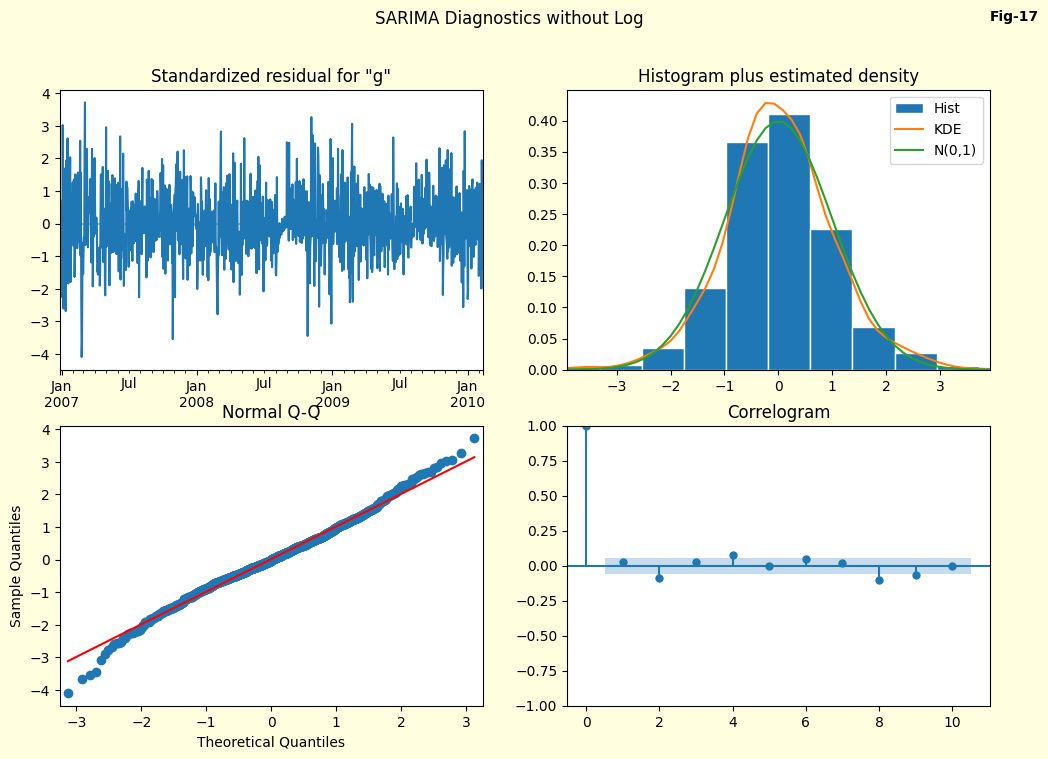

MAE : 0.772
RMSE: 0.709
MAPE: 100.89%


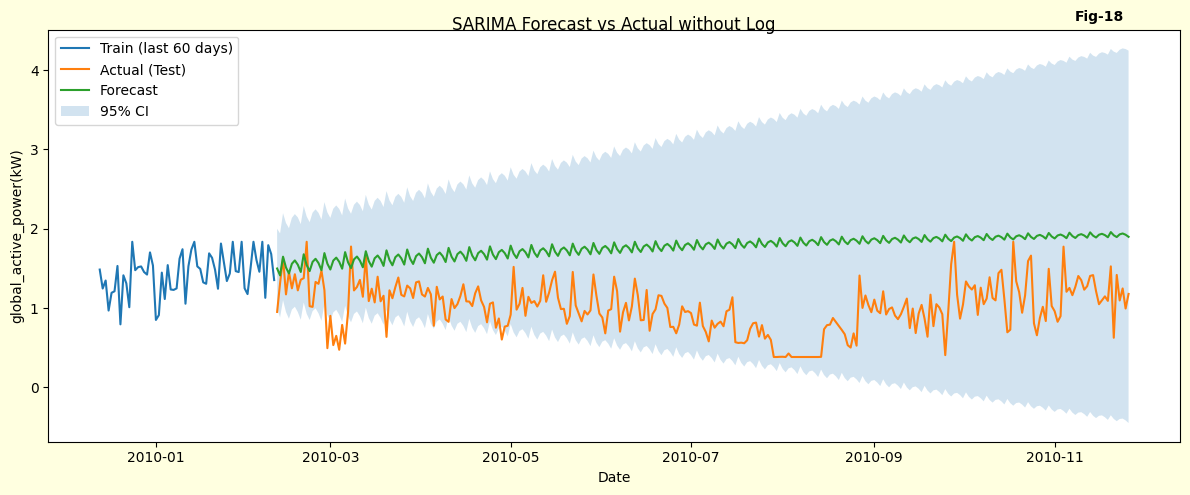

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, mean_squared_error

TARGET_COL = "global_active_power(kW)"
SEASON_LENGTH = 7
TEST_SIZE_RATIO = 0.2
USE_LOG = False


y = (df_daily[TARGET_COL]
     .asfreq('D')
     .interpolate(limit_direction='both'))

y_trans = np.log1p(y) if USE_LOG else y.copy()

split = int(len(y_trans) * (1 - TEST_SIZE_RATIO))
y_train, y_test = y_trans.iloc[:split], y_trans.iloc[split:]

candidate_orders = [(1,1,1), (2,1,1), (1,1,2)]
candidate_seasonals = [(0,1,1,SEASON_LENGTH), (1,1,1,SEASON_LENGTH), (1,0,1,SEASON_LENGTH)]

best_aic, best_cfg, best_res = np.inf, None, None

for order in candidate_orders:
    for seasonal_order in candidate_seasonals:
        try:
            model = sm.tsa.statespace.SARIMAX(
                y_train,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            res = model.fit(disp=False)
            if res.aic < best_aic:
                best_aic, best_cfg, best_res = res.aic, (order, seasonal_order), res
        except Exception as e:
            continue

print(f"Best AIC: {best_aic:.2f} with order={best_cfg[0]} seasonal_order={best_cfg[1]}")

fig_diagnostics = best_res.plot_diagnostics(figsize=(12, 8))
fig_diagnostics.patch.set_facecolor("lightyellow")
fig_diagnostics.text(0.9, 0.98, "Fig-17", fontsize=10, fontweight="bold", va="top", ha="left")
plt.suptitle("SARIMA Diagnostics without Log", y=0.98)
plt.show()

n_forecast = len(y_test)
pred = best_res.get_forecast(steps=n_forecast)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

if USE_LOG:
    y_test_eval = np.expm1(y_test)
    pred_series = pd.Series(np.expm1(pred_mean), index=y_test.index)
    pred_lower = np.expm1(pred_ci.iloc[:, 0])
    pred_upper = np.expm1(pred_ci.iloc[:, 1])
else:
    y_test_eval = y_test
    pred_series = pd.Series(pred_mean, index=y_test.index)
    pred_lower = pred_ci.iloc[:, 0]
    pred_upper = pred_ci.iloc[:, 1]

mae = mean_absolute_error(y_test_eval, pred_series)
rmse = mean_squared_error(y_test_eval, pred_series)
mape = (np.abs((y_test_eval - pred_series) / y_test_eval).replace([np.inf, -np.inf], np.nan).dropna()*100).mean()

print(f"MAE : {mae:,.3f}")
print(f"RMSE: {rmse:,.3f}")
print(f"MAPE: {mape:,.2f}%")


fig = plt.figure(figsize=(12, 5))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-18", fontsize=10, fontweight="bold", va="top", ha="left")

plt.plot(y.iloc[split-60:split], label="Train (last 60 days)")
plt.plot(y.iloc[split:], label="Actual (Test)")
plt.plot(pred_series, label="Forecast")
plt.fill_between(pred_series.index, pred_lower, pred_upper, alpha=0.2, label="95% CI")
plt.title("SARIMA Forecast vs Actual without Log", y=0.98)
plt.xlabel("Date"); plt.ylabel(TARGET_COL)
plt.legend()
plt.tight_layout()
plt.show()

### **2. Random Forest**

MAE: 0.166
RMSE: 0.235
R²   : 0.412
MAPE : 18.77%


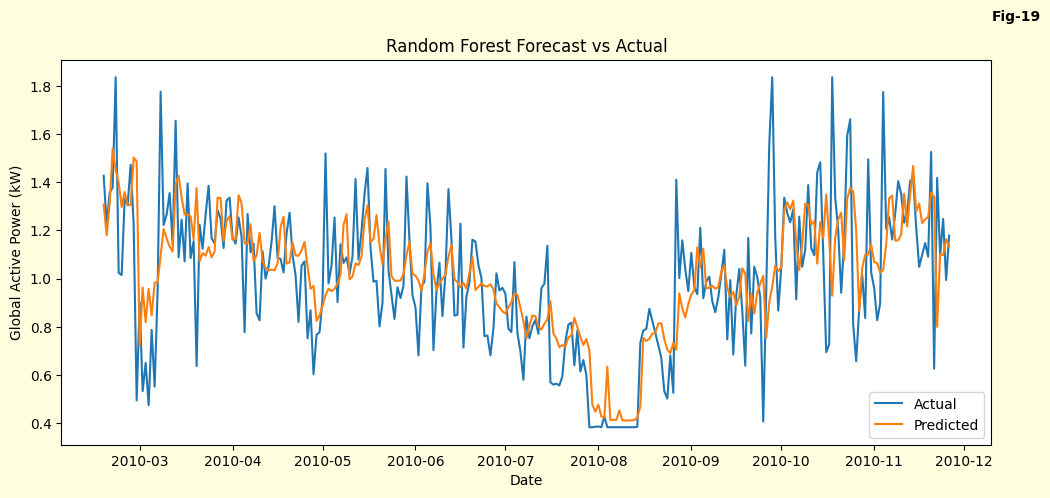

In [25]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 1. Load & Prepare Data
y = df_daily['global_active_power(kW)'].copy()

# Ensure daily frequency
y = y.asfreq('D').interpolate(limit_direction='both')

# Create lag features
def create_lag_features(series, lags=[1, 2, 7, 30]):
    df = pd.DataFrame({'y': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)
    # Rolling features
    df['rolling_mean_7'] = df['y'].shift(1).rolling(window=7).mean()
    df['rolling_mean_30'] = df['y'].shift(1).rolling(window=30).mean()
    # Calendar features
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

df_feat = create_lag_features(y)

# Drop NA rows created by shifting/rolling
df_feat = df_feat.dropna()

# 2. Train/Test Split
split = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:split], df_feat.iloc[split:]

X_train, y_train = train.drop(columns=['y']), train['y']
X_test, y_test = test.drop(columns=['y']), test['y']

# 3. Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Train Random Forest
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)

# 5. Prediction & Evaluation
y_pred = rf.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)
MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100   # in %

print(f"MAE: {MAE:.3f}")
print(f"RMSE: {RMSE:.3f}")
print(f"R²   : {R2:.3f}")
print(f"MAPE : {MAPE:.2f}%")

# 6. Plot Results
fig = plt.figure(figsize=(12, 5))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-19", fontsize=10, fontweight="bold", va="top", ha="left")
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Random Forest Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Global Active Power (kW)")
plt.legend()
plt.show()


In [26]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Initialize model
rf = RandomForestRegressor(random_state=42)

# Grid Search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,              # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)

print("Best Parameters:", grid_search.best_params_)
# best_model = grid_search.best_estimator_

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


Best params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
MAE  : 0.163
RMSE : 0.228
R²   : 0.446
MAPE : 18.25%


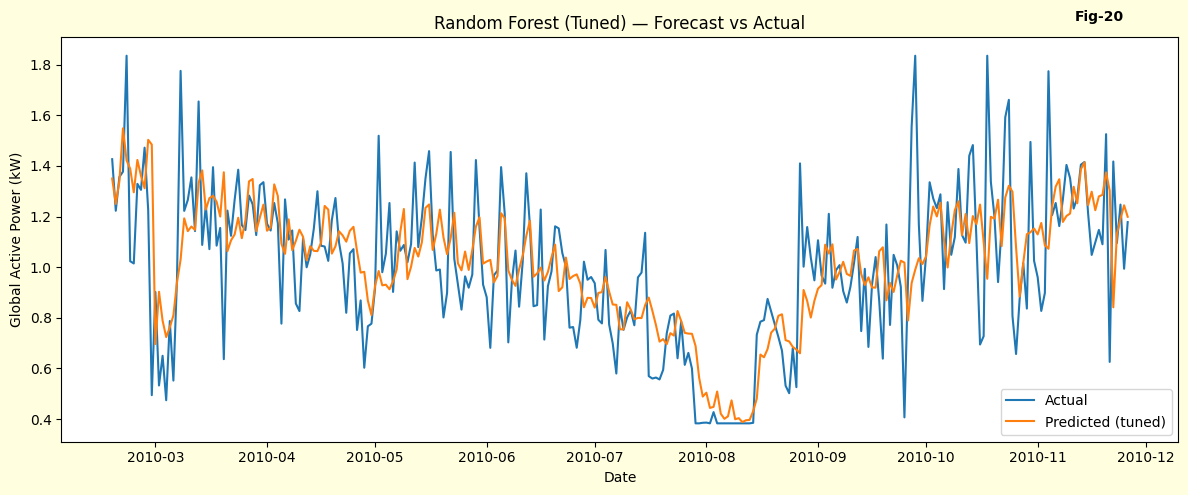

In [ ]:
best_params = grid_search.best_params_
rf_tuned = RandomForestRegressor(
    **best_params,
    random_state=42,
    n_jobs=-1
)

# 2) Fit on the (scaled) training data
rf_tuned.fit(X_train_scaled, y_train)

# 3) Predict on the (scaled) test data
y_pred_tuned = rf_tuned.predict(X_test_scaled)

# 4) Evaluate with full metrics
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae  = mean_absolute_error(y_test, y_pred_tuned)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
r2   = r2_score(y_test, y_pred_tuned)
mape = np.mean(np.abs((y_test - y_pred_tuned) / y_test)) * 100  # %

print("Best params:", best_params)
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")
print(f"MAPE : {mape:.2f}%")

# 5) Optional: plot

fig = plt.figure(figsize=(12,5))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-20", fontsize=10, fontweight="bold", va="top", ha="left")

plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred_tuned, label="Predicted (tuned)")
plt.title("Random Forest (Tuned) — Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Global Active Power (kW)")
plt.legend(); plt.tight_layout(); plt.show()

**3. XGBoost**

XGBOOST results:
MAE  : 0.183
RMSE : 0.253
R²   : 0.320
MAPE : 21.15%


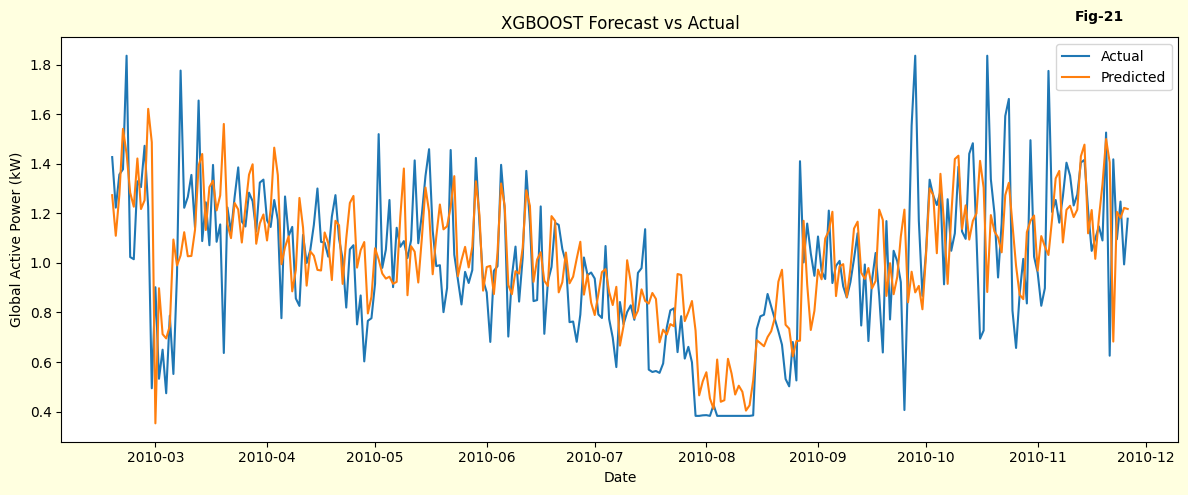

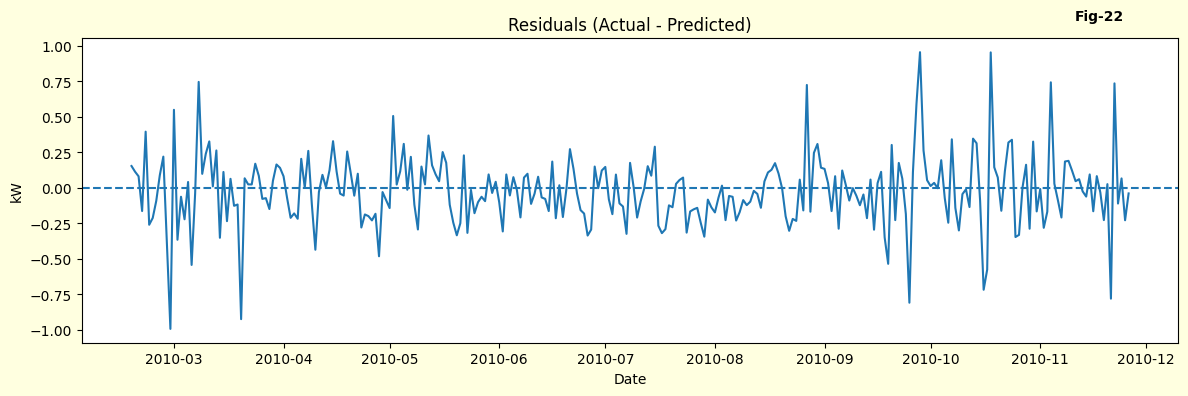

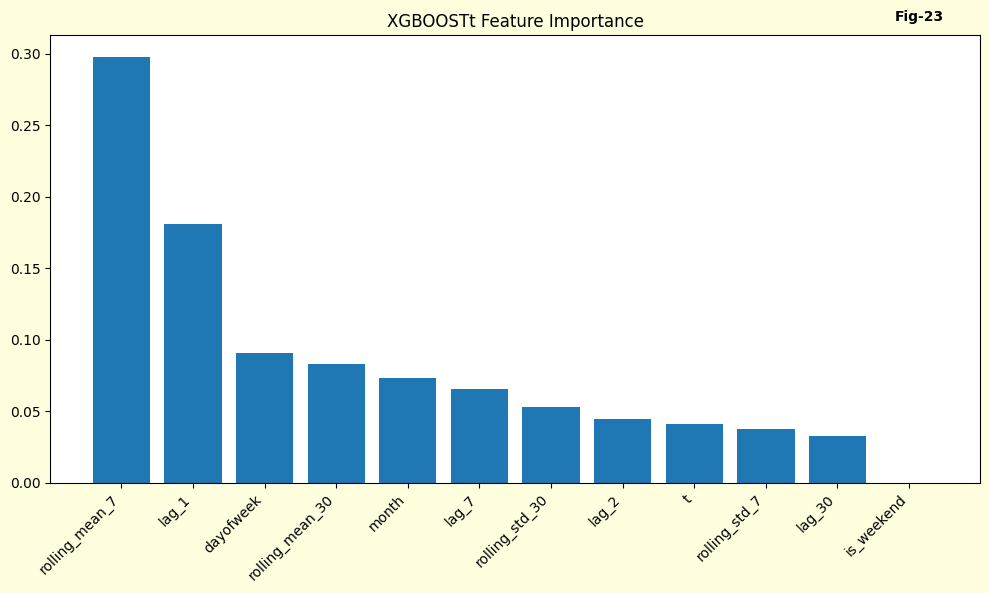

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import multiprocessing

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y = df_daily['global_active_power(kW)'].copy()

# y = y.asfreq('D').interpolate(limit_direction='both')

# -----------------------------
# 2) Feature engineering
# -----------------------------
def lag_features_creation(series, lags=[1, 2, 7, 30]):
    df = pd.DataFrame({'y': series})
    for lag in lags:
        df[f'lag_{lag}'] = df['y'].shift(lag)

    # Rolling stats (shift(1) to avoid leakage)
    df['rolling_mean_7']  = df['y'].shift(1).rolling(window=7,  min_periods=1).mean()
    df['rolling_mean_30'] = df['y'].shift(1).rolling(window=30, min_periods=1).mean()
    df['rolling_std_7']   = df['y'].shift(1).rolling(window=7,  min_periods=1).std()
    df['rolling_std_30']  = df['y'].shift(1).rolling(window=30, min_periods=1).std()

    # Calendar features
    df['dayofweek'] = df.index.dayofweek  # 0=Mon ... 6=Sun
    df['month']     = df.index.month      # 1..12
    df['is_weekend']= (df['dayofweek']>=5).astype(int)

    # (Optional) time index trend
    df['t'] = np.arange(len(df), dtype=np.int32)

    return df

df_feat = lag_features_creation(y)
df_feat = df_feat.dropna()

# 3) Chronological split
split = int(len(df_feat) * 0.8)
train, test = df_feat.iloc[:split], df_feat.iloc[split:]

X_train, y_train = train.drop(columns=['y']), train['y']
X_test,  y_test  = test.drop(columns=['y']),  test['y']

# Create a small validation slice from the tail of training for early stopping
val_frac = 0.1
val_size = max(1, int(len(X_train) * val_frac))
X_trn, y_trn = X_train.iloc[:-val_size], y_train.iloc[:-val_size]
X_val, y_val = X_train.iloc[-val_size:],  y_train.iloc[-val_size:]

# 4) Baseline XGBoost model
xgb = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.8,
    random_state=42,
    tree_method='hist'
)

xgb.fit(
    X_trn, y_trn,
    verbose=False,
)

# 5) Predict & evaluate
y_pred = xgb.predict(X_test)

mae  = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2   = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print("XGBOOST results:")
print(f"MAE  : {mae:.3f}")
print(f"RMSE : {rmse:.3f}")
print(f"R²   : {r2:.3f}")
print(f"MAPE : {mape:.2f}%")

# plots
# Forecast vs Actual
fig = plt.figure(figsize=(12,5))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-21", fontsize=10, fontweight="bold", va="top", ha="left")

plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("XGBOOST Forecast vs Actual")
plt.xlabel("Date"); plt.ylabel("Global Active Power (kW)")
plt.legend(); plt.tight_layout(); plt.show()

# Residuals
resid = y_test - y_pred
fig = plt.figure(figsize=(12,4))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-22", fontsize=10, fontweight="bold", va="top", ha="left")

plt.plot(y_test.index, resid)
plt.axhline(0, linestyle='--')
plt.title("Residuals (Actual - Predicted)")
plt.xlabel("Date"); plt.ylabel("kW")
plt.tight_layout(); plt.show()

# Feature importance
importances = xgb.feature_importances_
feat_order = np.argsort(importances)[::-1]
feat_names = X_train.columns[feat_order]
feat_vals  = importances[feat_order]

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor("lightyellow")
fig.text(0.9, 0.98, "Fig-23", fontsize=10, fontweight="bold", va="top", ha="left")

plt.bar(range(min(15, len(feat_vals))), feat_vals[:15])
plt.xticks(range(min(15, len(feat_vals))), feat_names[:15], rotation=45, ha='right')
plt.title("XGBOOSTt Feature Importance")
plt.tight_layout(); plt.show()

In [ ]:
import multiprocessing
import xgboost as xgb
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

X = df_feat.drop(columns=['y'])
y = df_feat['y']
tscv = TimeSeriesSplit(n_splits=3)
param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 500, 1000],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    tree_method="hist",
    n_jobs=-1
)
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    verbose=2,
    n_jobs=-1
)
grid_search.fit(X, y)

print("Best score:", grid_search.best_score_)
print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_

In [ ]:
!pip install -U xgboost